<a href="https://colab.research.google.com/github/nikolmash/compling-it2020/blob/master/hw2_compling%26it.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Задача о снижении размерности


## Работа с данными


Загружаю со своего гугл диска тексты разных жанров — фанфики, детскую литературу и детектив

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp /content/drive/My\ Drive/Фанфик.zip /content 
!cp /content/drive/My\ Drive/Детская.zip /content 
!cp /content/drive/My\ Drive/Детектив.zip /content 

In [ ]:
!unzip Фанфик.zip
!unzip Детская.zip
!unzip Детектив.zip

Archive:  Фанфик.zip
   creating: Фанфик/
  inflating: Фанфик/ryzhij_bwolk-1.txt  
  inflating: Фанфик/razengartedge.txt  
  inflating: Фанфик/opticheskij_o_zwparke.txt  
  inflating: Фанфик/wolkow_mihail_alekseewichrekost.txt  
  inflating: Фанфик/maks_ridonliotstranennostxsowkusomshokolada.txt  
  inflating: Фанфик/matweew_d_nnorth11.txt  
  inflating: Фанфик/nikitin_m_abarsoom.txt  
  inflating: Фанфик/sallypoetrywelltraveled.txt  
  inflating: Фанфик/triswjackaja_a_a10.txt  
  inflating: Фанфик/sokolow_m_aoverlord.txt  
  inflating: Фанфик/shejko_m_aps2.txt  
  inflating: Фанфик/wisenheimobs_bl.txt  
  inflating: Фанфик/proza_i_wnagai_kano.txt  
  inflating: Фанфик/prozorow_i_sbigharry.txt  
  inflating: Фанфик/palitko_s_aponyteology2.txt  
  inflating: Фанфик/sedrikprodolzheniefanfikapozwezdnymwojnam06102018.txt  
  inflating: Фанфик/shejko_m_aps3.txt  
  inflating: Фанфик/sengernaputikmechte.txt  
  inflating: Фанфик/sejtimbetow_samat_ajdosowichworm_coil.txt  
  inflating: Фанфик

Посмотрим сколько имеется текстов каждого жанра

In [ ]:
import os
import random

for dir in ('Фанфик', 'Детская', 'Детектив'):
  print(dir, len(os.listdir(dir)))

Фанфик 504
Детская 1007
Детектив 503


Примеров детской литературы больше всех.
Мы будем брать случайную подвыборку из 250 текстов. Тексты большого объема, поэтому этого количества должно хватить

In [ ]:
fanfics, children, detective = [],[],[]
fanfics_sample = random.sample(os.listdir('Фанфик'), 250)
for file in fanfics_sample:
  with open(os.path.join('Фанфик', file)) as f:
    fanfics.append(f.read())

detective_sample = random.sample(os.listdir('Детектив'), 250)
for file in detective_sample:
  with open(os.path.join('Детектив', file)) as f:
    text = f.read()
    detective.append(text)


children_sample = random.sample(os.listdir('Детская'), 250)
for file in children_sample:
  with open(os.path.join('Детская', file)) as f:
    children.append(f.read())

Переходим к препроцессингу:

In [ ]:
!pip install razdel
!python -m pip install pymorphy2[fast]

     |████████████████████████████████| 61kB 3.2MB/s 
     |████████████████████████████████| 8.0MB 6.1MB/s 
     |████████████████████████████████| 378kB 58.1MB/s 
  Created wheel for DAWG: filename=DAWG-0.8.0-cp36-cp36m-linux_x86_64.whl size=852066 sha256=ed2c6e1ebcccc5b3424d79223598c9f80d14a6408017614d3539581a7fb8ee91
  Stored in directory: /root/.cache/pip/wheels/3d/1f/f0/a5b1f9d02e193c997d252c33d215f24dfd7a448bc0166b2a12
Successfully built DAWG


Импортируем нужные библиотеки и загружаем необходимые объекты/сущности

In [ ]:
import re 
import nltk
import pymorphy2
from string import punctuation
from nltk.corpus import stopwords
from razdel import tokenize

nltk.download('stopwords')
stopwords = set(stopwords.words('russian'))
punkt = punctuation + '«»—…“”*№–'
morph = pymorphy2.MorphAnalyzer()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Пишем две функции:

tokenizing - делит текст на токены
preprocessing - основная предобработка текста. в ней:


*   убираются токены, являющиеся ссылкой, имейлом и токеном html. Эти вещи достаточно часто встречаются. Особенно в текстах из интернет-ресурсах, которыми являются эти тексты. Я вручную посмотрела несколько текстов и заметила много имейлов
*   убирается пунктуация и стоп-слова (они будут давать шум нашему векторайзеру)
*   токены лемматизируются (русский язык обладает широкой морфологией и нам ни к чему лишние слова в словаре
*   также я убираю все, кроме слов на русском и английском языках (токены состоящие из цифр здесь нам не пригодятся - создадут шум)
*   еще я убрала слова, состоящие из одной повторяющейся буквы (типа ааааааааа), их очень много



In [ ]:
def tokenizing(text):
  tokens = list(tokenize(text))
  return [_.text.lower() for _ in tokens]

def preprocessing(text):
  # регулярка честно найдена в интернете
  url_pattern = re.compile(r'((http|https)\:\/\/)?[a-zA-Z0-9\.\/\?\:@\-_=#]+\.([a-zA-Z]){2,6}([a-zA-Z0-9\.\&\/\?\:@\-_=#])*')
  # и эта тоже
  email_pattern = re.compile(r'[\w.-]+@[\w.-]+.\w+')
  html_pattern = re.compile(r'<.*?>')
  for pattern in (url_pattern, email_pattern, html_pattern):
    text = pattern.sub('', text)
  tokens = tokenizing(text)
  tokens = [x for x in tokens if x not in stopwords and x not in punkt]
  lemmas = [morph.parse(word)[0].normal_form for word in tokens]
  clean_text = ' '.join([word for word in lemmas if re.match('\W+', word) is None and re.match('\d+', word) is None])
  one_letter_words = re.compile(r'([а-яёa-z])\1{1,}')
  clean_text = one_letter_words.sub('', clean_text)
  return clean_text

Предобрабатываем все тексты:

In [ ]:
import pandas as pd
from tqdm.auto import tqdm

tqdm.pandas()
pr_detective = pd.Series(detective)
pr_detective = pr_detective.progress_apply(preprocessing)

In [ ]:
pr_fanfics = pd.Series(fanfics)
pr_fanfics = pr_fanfics.progress_apply(preprocessing)

In [ ]:
pr_children = pd.Series(children)
pr_children = pr_children.progress_apply(preprocessing)

Чтобы при выполнении этого ноутбука каждый раз не ждать предобработку, я сохранила обработанные тексты в csv к себе на диск

In [ ]:
pr_fanfics.to_csv('fanfics.csv', index=False)
pr_detective.to_csv('detective.csv', index=False)
pr_children.to_csv('children.csv', index=False)

In [ ]:
!cp /content/fanfics.csv /content/drive/My\ Drive/
!cp /content/detective.csv /content/drive/My\ Drive/
!cp /content/children.csv /content/drive/My\ Drive/

## Векторизация

Открываю те же предобработанные тексты со своего гугл диска

In [ ]:
import pandas as pd 

pr_fanfics = pd.read_csv('/content/drive/My Drive/fanfics.csv', names=['text'], header=0)
pr_detective = pd.read_csv('/content/drive/My Drive/detective.csv', names=['text'], header=0)
pr_children = pd.read_csv('/content/drive/My Drive/children.csv', names=['text'], header=0)

Я реализую векторизацию и эмбеддингами и с помощью BoW векторов.

Для эмбеддингов скачиваю модель fast text с rusvectores (tayga_none_fasttextcbow_300_10_2019) размер словаря почти 200 тысяч слов!

In [ ]:
!wget http://vectors.nlpl.eu/repository/20/187.zip
!unzip 187.zip

--2020-10-09 21:37:05--  http://vectors.nlpl.eu/repository/20/187.zip
Resolving vectors.nlpl.eu (vectors.nlpl.eu)... 129.240.189.225
Connecting to vectors.nlpl.eu (vectors.nlpl.eu)|129.240.189.225|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2692389554 (2.5G) [application/zip]
Saving to: ‘187.zip’

187.zip             100%[===================>]   2.51G  17.2MB/s    in 2m 36s  

2020-10-09 21:39:42 (16.4 MB/s) - ‘187.zip’ saved [2692389554/2692389554]

Archive:  187.zip
  inflating: meta.json               
  inflating: model.model             
  inflating: model.model.vectors_ngrams.npy  
  inflating: model.model.vectors.npy  
  inflating: model.model.vectors_vocab.npy  
  inflating: README                  


Для использования моделей нужна последняя версия gensim

In [ ]:
!pip install gensim --upgrade

     |████████████████████████████████| 24.2MB 131kB/s 
  Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0


In [ ]:
import gensim
from gensim.models import KeyedVectors

embeddings =  gensim.models.KeyedVectors.load('model.model')

Мы умеем доставать вектор для одного слова. А нужен вектор для целого текста

Самое простое решение - усреднить вектора всех слов. Напишем функцию для этого.

In [ ]:
import numpy as np


def text_to_vec(document, embeddings, dim=300):
    all_embs = []
    for word in tokenizing(document):
      if word in embeddings:
        all_embs.append(embeddings[word])
    # если вдруг в тексте ни одного слова из словаря модели - все нули
    if len(all_embs) == 0:
      return np.zeros(dim)
    return np.mean(all_embs,axis=0)

Векторизуем все тексты, предварительно избавившись от пропусков в данных

In [ ]:
pr_fanfics = pr_fanfics.dropna()
pr_fanfics['vector'] = pr_fanfics['text'].apply(lambda x: text_to_vec(x, embeddings))

pr_children = pr_children.dropna()
pr_children['vector'] = pr_children['text'].apply(lambda x: text_to_vec(x, embeddings))

pr_detective = pr_detective.dropna()
pr_detective['vector'] = pr_detective['text'].apply(lambda x: text_to_vec(x, embeddings))

pr_fanfics['genre'] = 'Фанфик'
pr_children['genre'] = 'Детям'
pr_detective['genre'] = 'Детектив'

Для визуализации нужен отдельный датафрейм со всеми текстами (вернее, уже их эмбеддингами), отдельный - с их жанрами

In [ ]:
vectors = pd.concat([pr_fanfics['vector'], pr_children['vector'], pr_detective['vector']], ignore_index=True).values
labels = pd.concat([pr_fanfics['genre'], pr_children['genre'], pr_detective['genre']], ignore_index=True).values

## Визуализация


### PCA

Построим график PCA для эмбеддингов fasttext 

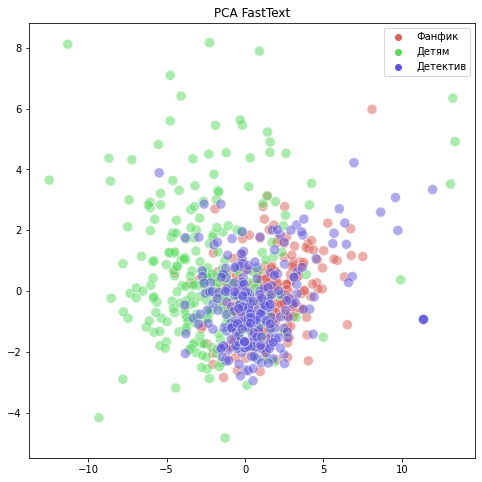

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
plt.rcParams["figure.figsize"] = (8,8)

pca = PCA(n_components=2)
vec_proj = pca.fit_transform(np.stack(vectors))

sns.scatterplot(x=vec_proj[:, 0], y=vec_proj[:, 1], hue=labels, alpha=0.5,
                palette=sns.color_palette("hls", 3), s=100)
plt.title('PCA FastText')
plt.show()

Точки совсем не располагаются вдоль прямых, но в принципе хорошо видно, что детский жанр мало общего имеет с двумя другими

Попробуем с TF-IDF векторами:

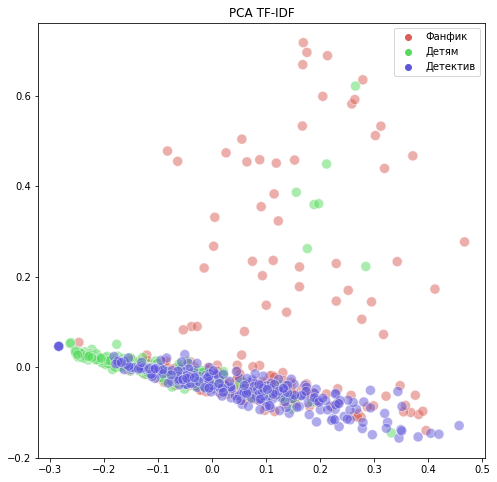

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

vec = TfidfVectorizer()
X = vec.fit_transform(pd.concat([pr_fanfics['text'], pr_children['text'], pr_detective['text']], ignore_index=True))
pca = PCA(n_components=2)
X_proj = pca.fit_transform(X.todense())

sns.scatterplot(x=X_proj[:, 0], y=X_proj[:, 1], hue=labels, alpha=0.5, 
                palette=sns.color_palette("hls", 3), s=100)
plt.title('PCA TF-IDF')
plt.show()

Теперь действительно точки расположились вдоль одной прямой

### t-SNE

Построим график tSNE для эмбеддингов fasttext

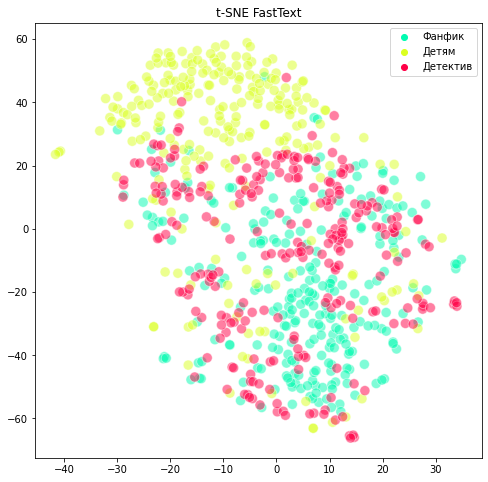

In [ ]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=15, random_state=0)
vec_proj = tsne.fit_transform(np.stack(vectors))

sns.scatterplot(x=vec_proj[:, 0], y=vec_proj[:, 1], hue=labels, alpha=0.5,
                palette=sns.color_palette("gist_ncar", 3), s=100)
plt.title('t-SNE FastText')
plt.show()

Снова хорошо виден отдельный кластер детской литературы

Визуализируем BoW векторы:

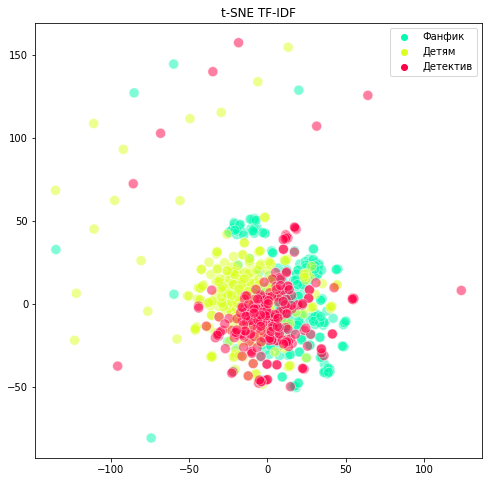

In [ ]:
tsne = TSNE(n_components=2, perplexity=15, random_state=0)
X_proj = tsne.fit_transform(X.todense())

sns.scatterplot(x=X_proj[:, 0], y=X_proj[:, 1], hue=labels, alpha=0.5, 
                palette=sns.color_palette("gist_ncar", 3), s=100)
plt.title('t-SNE TF-IDF')
plt.show()

В отличие от предыдущего графика, все более компактно. Хорошо выделился детский кластер и детектив

# Задача о тематическом моделировании

## Махинации с kaggle


Открою данные с самой платформы kaggle:

In [1]:
! pip install -q kaggle

In [2]:
from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"marianikolaenkova","key":"840fd9c4513627472030c6e584baa19f"}'}

In [3]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [4]:
! kaggle datasets download -d kaggle/hillary-clinton-emails

 41% 5.00M/12.2M [00:00<00:00, 40.7MB/s]
100% 12.2M/12.2M [00:00<00:00, 78.2MB/s]


In [5]:
!unzip hillary-clinton-emails.zip

Archive:  hillary-clinton-emails.zip
  inflating: Aliases.csv             
  inflating: EmailReceivers.csv      
  inflating: Emails.csv              
  inflating: Persons.csv             
  inflating: database.sqlite         
  inflating: hashes.txt              


## Работа с данными


Перейдем к предобработке

In [6]:
import re
import nltk
import spacy
import pandas as pd
from tqdm.auto import tqdm
from string import punctuation
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

In [7]:
emails = pd.read_csv('Emails.csv')
emails.head()

,Id,DocNumber,MetadataSubject,MetadataTo,MetadataFrom,SenderPersonId,MetadataDateSent,MetadataDateReleased,MetadataPdfLink,MetadataCaseNumber,MetadataDocumentClass,ExtractedSubject,ExtractedTo,ExtractedFrom,ExtractedCc,ExtractedDateSent,ExtractedCaseNumber,ExtractedDocNumber,ExtractedDateReleased,ExtractedReleaseInPartOrFull,ExtractedBodyText,RawText
0,1,C05739545,WOW,H,"Sullivan, Jacob J",87.0,2012-09-12T04:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH2/DOC_0C05739545...,F-2015-04841,HRC_Email_296,FW: Wow,NaN,"Sullivan, Jacob J <Sullivan11@state.gov>",NaN,"Wednesday, September 12, 2012 10:16 AM",F-2015-04841,C05739545,05/13/2015,RELEASE IN FULL,NaN,UNCLASSIFIED\nU.S. Department of State\nCase N...
1,2,C05739546,H: LATEST: HOW SYRIA IS AIDING QADDAFI AND MOR...,H,NaN,NaN,2011-03-03T05:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH1/DOC_0C05739546...,F-2015-04841,HRC_Email_296,NaN,NaN,NaN,NaN,NaN,F-2015-04841,C05739546,05/13/2015,RELEASE IN PART,"B6\nThursday, March 3, 2011 9:45 PM\nH: Latest...",UNCLASSIFIED\nU.S. Department of State\nCase N...
2,3,C05739547,CHRIS STEVENS,;H,"Mills, Cheryl D",32.0,2012-09-12T04:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH2/DOC_0C05739547...,F-2015-04841,HRC_Email_296,Re: Chris Stevens,B6,"Mills, Cheryl D <MillsCD@state.gov>","Abedin, Huma","Wednesday, September 12, 2012 11:52 AM",F-2015-04841,C05739547,05/14/2015,RELEASE IN PART,Thx,UNCLASSIFIED\nU.S. Department of State\nCase N...
3,4,C05739550,CAIRO CONDEMNATION - FINAL,H,"Mills, Cheryl D",32.0,2012-09-12T04:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH2/DOC_0C05739550...,F-2015-04841,HRC_Email_296,FVV: Cairo Condemnation - Final,NaN,"Mills, Cheryl D <MillsCD@state.gov>","Mitchell, Andrew B","Wednesday, September 12,2012 12:44 PM",F-2015-04841,C05739550,05/13/2015,RELEASE IN PART,NaN,UNCLASSIFIED\nU.S. Department of State\nCase N...
4,5,C05739554,H: LATEST: HOW SYRIA IS AIDING QADDAFI AND MOR...,"Abedin, Huma",H,80.0,2011-03-11T05:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH1/DOC_0C05739554...,F-2015-04841,HRC_Email_296,NaN,NaN,NaN,NaN,NaN,F-2015-04841,C05739554,05/13/2015,RELEASE IN PART,"H <hrod17@clintonemail.com>\nFriday, March 11,...",B6\nUNCLASSIFIED\nU.S. Department of State\nCa...


Хотя в датасете и есть колонка ExtractedBodyText, она мне не нравится, потому что там очень много пропусков, достаточно много мусора, и убрать его тяжело, потому что нет какой-либо структуры. В колонке же RawText все тексты имеют один формат и почистить их будет проще.

Посмотрим на пример письма оттуда

In [8]:
email_texts = emails['RawText'].dropna()
print(email_texts[0])

UNCLASSIFIED
U.S. Department of State
Case No. F-2015-04841
Doc No. C05739545
Date: 05/13/2015
STATE DEPT. - PRODUCED TO HOUSE SELECT BENGHAZI COMM.
SUBJECT TO AGREEMENT ON SENSITIVE INFORMATION & REDACTIONS. NO FOIA WAIVER.
RELEASE IN FULL
From: Sullivan, Jacob J <Sullivan11@state.gov>
Sent: Wednesday, September 12, 2012 10:16 AM
To:
Subject: FW: Wow
From: Brose, Christian (Armed Services) (mailto:Christian_Brose@armed-servic,essenate.govi
Sent: Wednesday, September 12, 2012 10:09 AM
To: Sullivan, Jacob J
Subject: Wow
What a wonderful, strong and moving statement by your boss. please tell her how much Sen. McCain appreciated it. Me
too
UNCLASSIFIED
U.S. Department of State
Case No. F-2015-04841
Doc No. C05739545
Date: 05/13/2015
STATE DEPT. - PRODUCED TO HOUSE SELECT BENGHAZI COMM.
SUBJECT TO AGREEMENT ON SENSITIVE INFORMATION & REDACTIONS. NO FOIA WAIVER. STATE-5CB0045247



Наблюдаем очень много метаинформации о письме - дата, отправитель, получатель и т.д. Напишем функцию, которая все это уберет регулярками

In [9]:
def rawtext_extracting(text) -> str:
  meta_pattern1 = re.compile(r'(From|Sent|To|From|Subject|Cc|CC|cc|Date|Fw|Re|For|Attachments|H):.*?\n')
  meta_pattern2 = re.compile(r'(UNCLASSIFIED|U.S. Department of State|RELEASE IN|FULL|RELEASE IN FULL|CONFIDENTIAL)\n')
  meta_pattern3 = re.compile(r'(SUBJECT|Sent|Doc No.|Case No.|STATE|Subject|UNCLASSIFIED|B6|B5|RELEASE IN|PART|hre|hrc).*?(\n|\x0c)')
  meta_pattern4 = re.compile(r'\n.*?Original Message.*?\n')
  email_pattern = re.compile(r'<?[a-zA-Z0-9]+@[a-z.'']+>?')
  url_pattern = re.compile(r'htte?p?s?://\S+|www\.\S+')
  raw_text = meta_pattern1.sub('', text)
  raw_text = meta_pattern2.sub('', raw_text)
  raw_text = meta_pattern3.sub('', raw_text)
  raw_text = meta_pattern4.sub('', raw_text)
  raw_text = email_pattern.sub('', raw_text)
  raw_text = url_pattern.sub('', raw_text)
  return raw_text

Посмотрим что получилось:

In [10]:
print(rawtext_extracting(email_texts[0]))
print(rawtext_extracting(email_texts[25]))

What a wonderful, strong and moving statement by your boss. please tell her how much Sen. McCain appreciated it. Me
too

Sidney Blumenthal
Thursday, September 13, 2012 12:29 AM
September 13, 2012
SOURCE: Sources with direct access to the Libyan National Transitional Council, as well as the
highest levels of European Governments, and Western Intelligence and security services.
1.On September 12, 2012 Libyan President Mohammed Yussef el Magariaf told senior
advisors that the death of the U.S. Ambassador at the hands of Islamist militia forces represents a
ta sensitive source, el Magariaf believes that the primary goal of this and other attacks on Western
facilities is to demonstrate that the GNC cannot protect its non-Islamic friends. Libyan security
officials believe that the attack was carried out by forces of the Islamist militia group calling itself the
Ansar al Sharia brigade; working out of camps in the Eastern suburbs of Benghazi. These officials
added that their sources indicate

Остался только текст! 
Во втором примере остались даты, и в других текстах, скорее всего тоже. Уберем их дополнительно с помощью NER из spacy

Что касается предобработки: убираем также url, email, html-теги, потому что опять же в электронных ресурсах этих вещей может быть много. Убираем стоп-слова и пунктуацию, а также я убираю все, кроме английских слов и слова длины 1. В данной задаче нам нужны и важны только английские значащие слова 

In [11]:
nlp = spacy.load("en_core_web_sm")
nltk.download('stopwords')
nltk.download('wordnet')
stopwords = stopwords.words('english')
punkt = punctuation + '«»—…“”*№–'
lemmatizer = WordNetLemmatizer()

def remove_dates(text) -> str:
  doc = nlp(text)
  clean_text = text
  for ent in doc.ents:
    if ent.label_ == 'DATE':
      clean_text = clean_text.replace(text[ent.start_char:ent.end_char], '')
  return clean_text


def preprocessing(text) -> str:
  url_pattern = re.compile(r'((http|https)\:\/\/)?[a-zA-Z0-9\.\/\?\:@\-_=#]+\.([a-zA-Z]){2,6}([a-zA-Z0-9\.\&\/\?\:@\-_=#])*')
  email_pattern = re.compile(r'[\w.-]+@[\w.-]+.\w+')
  html_pattern = re.compile(r'<.*?>')
  for pattern in (url_pattern, email_pattern, html_pattern):
    text = pattern.sub('', text)
  doc = nlp(text)
  #токенизируем, убираем стоп-слова и пунктуацию
  tokens = [token.text.lower() for token in doc if token.text.lower() not in stopwords and token.text.lower() not in punkt]
  lemmas = [lemmatizer.lemmatize(word) for word in tokens]
  clean_text = ' '.join([word for word in lemmas if re.match(r'^[a-z+]+$', word) is not None and len(word)>1])
  return clean_text

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [12]:
tqdm.pandas()
email_texts = email_texts.progress_apply(lambda x:preprocessing(rawtext_extracting(remove_dates(x))))
texts = [text for text in email_texts if len(text)>100]

## Выделение тем с помощью LDA

In [13]:
import gensim
from scipy.sparse import csc
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

Создаем BoW векторы наших текстов и создаем словарь формата gensim, который необходим для LDA модели

In [14]:
vectorizer = CountVectorizer(min_df=10)
X = vectorizer.fit_transform(texts)

In [15]:
vocab = vectorizer.get_feature_names()
corpus = gensim.matutils.Sparse2Corpus(csc.csc_matrix(X))
dictionary = gensim.corpora.Dictionary.from_corpus(corpus, dict([(i, s) for i, s in enumerate(vocab)]))

In [16]:
model = gensim.models.ldamodel.LdaModel(
    corpus=corpus,
    id2word=dictionary,
    num_topics=10,
)

In [18]:
model.print_topics(num_words=5)

[(0,
  '0.019*"acknowledgement" + 0.009*"inability" + 0.009*"inaccurate" + 0.007*"impeachment" + 0.005*"justify"'),
 (1,
  '0.013*"martin" + 0.011*"memcon" + 0.010*"irony" + 0.009*"involvement" + 0.009*"legally"'),
 (2,
  '0.031*"independently" + 0.029*"edward" + 0.017*"abuse" + 0.016*"africa" + 0.007*"breakout"'),
 (3,
  '0.014*"connecting" + 0.011*"independently" + 0.010*"encounter" + 0.010*"encoding" + 0.010*"khaleda"'),
 (4,
  '0.019*"deteriorated" + 0.019*"domestically" + 0.019*"asserted" + 0.009*"insurance" + 0.009*"outspoken"'),
 (5,
  '0.010*"expressed" + 0.010*"bi" + 0.010*"bias" + 0.010*"equal" + 0.010*"involvement"'),
 (6,
  '0.019*"manning" + 0.019*"inaccurate" + 0.018*"inability" + 0.010*"involvement" + 0.010*"correspondence"'),
 (7,
  '0.011*"air" + 0.010*"active" + 0.009*"advocating" + 0.009*"affecting" + 0.008*"alberto"'),
 (8,
  '0.012*"abuse" + 0.011*"africa" + 0.007*"khaleda" + 0.007*"chosen" + 0.006*"martin"'),
 (9,
  '0.007*"inaccurate" + 0.007*"inability" + 0.006*

Модель выделила 10 тем и все они более или менее интерпретируемые, хоть, конечно, и без контекста достаточно тяжело понять. Более того, все усложняет особый формальный стиль переписки, сожные слова

тема 8 явно затрагивают проблему насилия в африке (в 5 еще есть имена, например , Khaleda - бывший премьер министр Бангладеша. Не исключено что с ней было какое-то обсуждение)

про Халеду - также тема 3, тут же присутствует слова "связываться" и "знакомый"


тема 0 - присутствует слово импичмент, что очень характерно для политики Америки (а также логичные для такого события слова "оправдать", "неспособность", "подтверждение")





Попробуем то же самое с tf-idf векторами:

In [19]:
vectorizer = TfidfVectorizer(min_df=10, max_df=0.9)
X = vectorizer.fit_transform(texts)

In [20]:
vocab = vectorizer.get_feature_names()
corpus = gensim.matutils.Sparse2Corpus(csc.csc_matrix(X))
dictionary = gensim.corpora.Dictionary.from_corpus(corpus, dict([(i, s) for i, s in enumerate(vocab)]))

In [21]:
model = gensim.models.ldamodel.LdaModel(
    corpus=corpus,
    id2word=dictionary,
    num_topics=10
)

In [22]:
model.print_topics(num_words=5)

[(0,
  '0.007*"counternarcotics" + 0.006*"kitchen" + 0.005*"circulating" + 0.005*"aung" + 0.004*"keib"'),
 (1,
  '0.004*"defending" + 0.004*"attach" + 0.003*"deficiency" + 0.003*"appreciate" + 0.003*"congolese"'),
 (2,
  '0.010*"involving" + 0.008*"ann" + 0.007*"catch" + 0.006*"mexico" + 0.006*"half"'),
 (3,
  '0.005*"peacekeeping" + 0.005*"mcguinness" + 0.005*"meanwhile" + 0.005*"measurable" + 0.005*"observation"'),
 (4,
  '0.003*"continuous" + 0.002*"court" + 0.002*"noon" + 0.002*"environment" + 0.002*"involves"'),
 (5,
  '0.007*"kuwait" + 0.007*"kyl" + 0.006*"kyi" + 0.006*"extremist" + 0.006*"kurt"'),
 (6,
  '0.003*"credited" + 0.003*"criticizing" + 0.003*"criticize" + 0.003*"criticizes" + 0.003*"arrival"'),
 (7,
  '0.001*"africa" + 0.001*"abuse" + 0.001*"destroy" + 0.001*"destroyed" + 0.001*"doug"'),
 (8,
  '0.001*"mellott" + 0.001*"draconian" + 0.001*"concentrate" + 0.001*"dprk" + 0.001*"capacity"'),
 (9,
  '0.003*"empathy" + 0.003*"apec" + 0.003*"consul" + 0.003*"directing" + 0.0

Не кажется, что темы стали более осознаннее, но они явно другие

тема 5 - возможно, про теракт в Кувейте, есть имя политика Kyi, которое также возможно участвовала в каком-то обсуждении
7 - снова насилие в африке (слово уничтожить тоже сюда подходит)
0 - я нашла высказывания политиков с фамилиями Aung и Keib про движение counternarcotics. скорее всего, они имеет к нему самое прямое отношение.

In [25]:
!pip install pyLDAvis

     |████████████████████████████████| 1.6MB 9.5MB/s 
  Created wheel for pyLDAvis: filename=pyLDAvis-2.1.2-py2.py3-none-any.whl size=97712 sha256=df2b545b5004afc30916b6ac3a786d5576afba2647011cdc182d8641a62c327c
  Stored in directory: /root/.cache/pip/wheels/98/71/24/513a99e58bb6b8465bae4d2d5e9dba8f0bef8179e3051ac414
Successfully built pyLDAvis


In [28]:
import pyLDAvis
import pyLDAvis.gensim  
import matplotlib.pyplot as plt
%matplotlib inline

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(model, corpus, dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
7     -0.131771 -0.045042       1        1  33.730568
8     -0.057175  0.029491       2        1  29.773413
6     -0.017816  0.162315       3        1   9.535191
4      0.030730 -0.047691       4        1   8.409356
9     -0.107202 -0.060485       5        1   6.249890
1      0.022600  0.020886       6        1   3.298448
3      0.111109 -0.070968       7        1   3.208209
0      0.018087 -0.003099       8        1   2.182116
2      0.053646  0.001731       9        1   1.816436
5      0.077792  0.012861      10        1   1.796373, topic_info=             Term       Freq      Total Category  logprob  loglift
381     apartment  11.000000  11.000000  Default  30.0000  30.0000
3944    involving   9.000000   9.000000  Default  29.0000  29.0000
4189          kyl  10.000000  10.000000  Default  28.0000  28.0000
4188          kyi  10.000000  10.000000  Default  27.0000  27.0000
952     brownback  10.000000  10.000000  Default  26.0000  26.0000
...           ...        ...        ...      ...      ...      ...
952     brownback   3.198901  10.276917  Topic10  -5.4247   2.8523
954      brussels   3.026123  10.719231  Topic10  -5.4802   2.7546
1633  cooperating   2.271428   6.422607  Topic10  -5.7671   2.9800
4150      kingdom   2.398597   7.328837  Topic10  -5.7126   2.9025
1582    continent   2.351744  11.768196  Topic10  -5.7323   2.4092

[528 rows x 6 columns], token_table=      Topic      Freq          Term
term                               
11        1  0.755588      abdullah
11        2  0.125931      abdullah
11        3  0.062966      abdullah
11        4  0.062966      abdullah
11        5  0.062966      abdullah
...     ...       ...           ...
5318      5  0.844005       painful
5339      6  0.850493       panetta
5401      2  0.880376       patrick
5423      2  0.206736  peacekeeping
5423      7  0.723575  peacekeeping

[898 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[8, 9, 7, 5, 10, 2, 4, 1, 3, 6])